<a href="https://colab.research.google.com/github/MontiMic/Progetto/blob/main/Presentazione_progetto_sui_file_di_log.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from imblearn.under_sampling import RandomUnderSampler

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Importiamo i dati grezzi

In [2]:
data_url = "https://raw.githubusercontent.com/MontiMic/Progetto/main/CIDDS-001-external-week1.csv"
data = pd.read_csv(data_url, sep=',', dtype={})

In [3]:
data.head(3)

,Date first seen,Duration,Proto,Src IP Addr,Src Pt,Dst IP Addr,Dst Pt,Packets,Bytes,Flows,Flags,Tos,class,attackType,attackID,attackDescription
0,2017-03-14 17:43:57.172,81412.697,TCP,EXT_SERVER,8082,OPENSTACK_NET,56978.0,3057,2.1 M,1,.AP...,0,normal,---,---,---
1,2017-03-14 17:43:57.172,81412.697,TCP,OPENSTACK_NET,56978,EXT_SERVER,8082.0,4748,2.5 M,1,.AP...,0,normal,---,---,---
2,2017-03-14 17:43:26.135,81504.787,TCP,EXT_SERVER,8082,OPENSTACK_NET,56979.0,8639,9.1 M,1,.AP...,0,normal,---,---,---


In [4]:
cell_features = ["date_first_seen", "duration",
                 "proto", "src_ip_addr",
                 "src_pt", "dst_ip_addr",
                 "dst_pt", "packets",
                 "bytes", "flows",
                 "flag", "tos",
                 "class", "attack_type",
                 "attack_id", "attack_description"]
data.columns = [i for i in cell_features]

Inizialmente i log sono distribuiti tra sospetti, normali e sconosciuti come si può osservare dal grafico

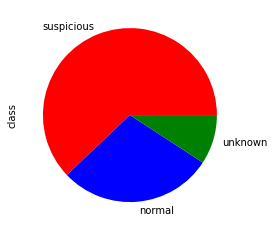

In [5]:
data["class"].value_counts().plot.pie(colors=["red", "blue", "green"]);

Per rendere utilizzabile il dato dei bytes transitati sostituiamo tutte le occorrenze in cui vengono sintetizzati in "mega" con il numero effettivo di bytes

In [6]:
bytes = []
for i in data["bytes"]:
  if 'M' in i:
    i = i.replace("M", "")
    i = float(i) * 1_000_000
    i = int(i)
  else:
    i = int(i)
  bytes.append(i)
data = data.drop('bytes', 1)
data.insert(7, 'bytes', bytes)

Ed avendo dati campionati tutti nella stessa settimana, riduciamo la data al giorno per poterla utilizzare come parametro per dividere il set

In [7]:
day = []
for i in data["date_first_seen"]:
  i = i[8:10]
  i = int(i)
  day.append(i)
data = data.drop('date_first_seen', 1)
data.insert(0, 'day_first_seen', day)

Essendo i dati "unknown" poco interessanti per il problema, lo semplifichiamo rimuovendoli

In [8]:
data = data[data["class"] != "unknown"]

Osserviamo che i dati si distribuisco in modo bilanciato tra precedenti e successivi al giorno 18

In [9]:
pd.qcut(data["day_first_seen"], 2).value_counts(normalize=True)

(13.999, 18.0]    0.526002
(18.0, 21.0]      0.473998
Name: day_first_seen, dtype: float64

E dividiamo quindi il set tra dati precedenti e successivi al 18

In [10]:
data1 = data.copy()
data1["day_first_seen"] = data1["day_first_seen"][data1["day_first_seen"] < 18]
data2 = data.copy()
data2["day_first_seen"] = data2["day_first_seen"][data2["day_first_seen"] > 17]

A questo punto la distribuzione tra sospetti e normali si presenta in questo modo.
Notiamo uno sbilanciamento verso la classe dei sospetti ma di questo ci occuperemo più avanti

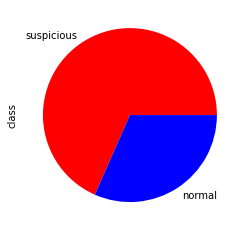

In [11]:
data["class"].value_counts().plot.pie(colors=["red", "blue"]);

In [12]:
classification_color_map = {"normal":"blue", "suspicious":"red"}
classification_colors = data["class"].map(classification_color_map)

Dal grafico emerge un modello che correla l'attività sospetta alla conformazione del traffico dati

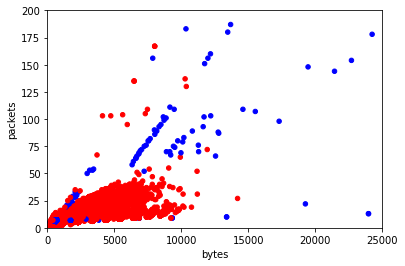

In [13]:
data.plot.scatter("bytes", "packets", c=classification_colors)
plt.axis([0, 25000, 0, 200]);

Useremo quindi "bytes" e "packets" come variabili predittive per provare a predire se un log corrisponde o meno ad attività sospetta, usando solo i dati relativi alla metà meno recente

In [14]:
y = data1["class"]
X = data1[["bytes", "packets"]]

E dividiamo il dataset in training set (2/3) e validation set (1/3)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=1/3, random_state=42)

Il modello scelto è un "decision tree classifier" a cui applicheremo una grid search di tipo "stratified KFold"

In [16]:
skf = StratifiedKFold(3, shuffle=True, random_state=1337)

In [17]:
tree_pipeline = Pipeline([
  ("tree", DecisionTreeClassifier(random_state=1337))
])
grid = {
  "tree__min_samples_split": [5, 2, 0.02, 0.05, 0.1],
  "tree__max_depth": [i for i in range(2, 7)],
}
tree_model = GridSearchCV(tree_pipeline, grid, cv=skf)
tree_model.fit(X_train, y_train)
tree_model.score(X_val, y_val), tree_model.best_params_

(0.9952405527839899, {'tree__max_depth': 6, 'tree__min_samples_split': 5})

Usiamo una matrice di confusione per visualizzare i risultati del modello

In [18]:
def display_model_metrics(model, X, y):
  y_pred = model.predict(X)

  conf_matrix = pd.DataFrame(confusion_matrix(y, y_pred))
  precision = precision_score(y, y_pred, zero_division=0, pos_label="suspicious")
  recall = recall_score(y, y_pred, pos_label="suspicious")
  f1 = f1_score(y, y_pred, pos_label="suspicious")
  accuracy = accuracy_score(y, y_pred)

  print(f"""{conf_matrix}\n\n \
Precision: {precision}\n \
Recall: {recall}\n \
F1 Score: {f1}\n \
Accuracy: {accuracy}\n""")

In [19]:
display_model_metrics(tree_model, X_val, y_val)

       0      1
0  16369    133
1    116  35699

 Precision: 0.9962882339807992
 Recall: 0.9967611336032388
 F1 Score: 0.9965246276885285
 Accuracy: 0.9952405527839899



E con un'altra matrice di confusione validiamo il modello sull'intera metà del set relativa ai dati più recenti (che il modello non ha ancora mai visto)

In [21]:
y_val = data2["class"]
X_val = data2[["bytes", "packets"]]
display_model_metrics(tree_model, X_val, y_val)

       0       1
0  49232     374
1    307  107037

 Precision: 0.9965180474997906
 Recall: 0.9971400357728425
 F1 Score: 0.9968289446113012
 Accuracy: 0.995661038547308



Così è come si presenta l'albero decisionale che è emerso

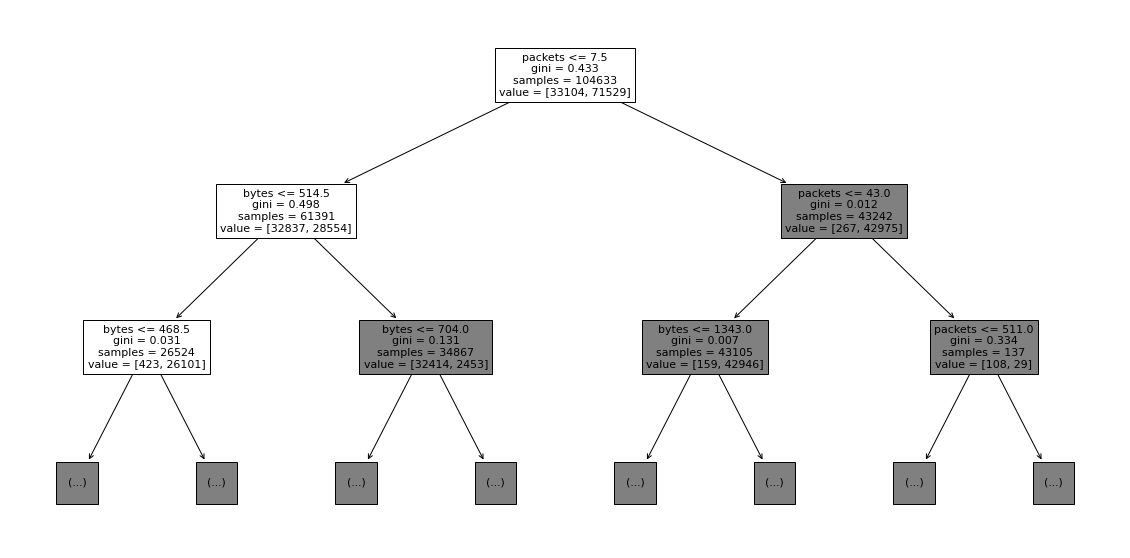

In [22]:
plt.figure(figsize=(20, 10))
plot_tree(tree_model.best_estimator_.named_steps["tree"], feature_names=X_val.columns, max_depth=2);

E visualizziamo anche come si presenta il modello osservando come classificherebbe ogni punto del piano

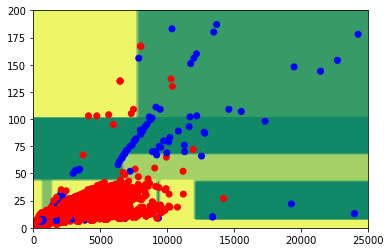

In [23]:
mx1, mx2 = np.meshgrid(np.linspace(0, 25_000, 100), np.linspace(0, 200, 100))
my = tree_model.predict_proba(np.c_[mx1.ravel(), mx2.ravel()])[:, 1].reshape(mx1.shape)
plt.contourf(mx1, mx2, my, cmap="summer")
plt.scatter(X_val["bytes"], X_val["packets"], c=y_val.map(classification_color_map))
plt.axis([0, 25_000, 0, 200]);

Il modello funziona bene nonostante lo sbilanciamento nella distribuzione dei dati ma per completezza riaddestriamo il modello applicando un "random under sampler" per lavorare con dati equidistribuiti

In [26]:
y = data1["class"]
X = data1[["bytes", "packets"]]
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=1/3, random_state=42)

In [27]:
rus = RandomUnderSampler(random_state=1337)
X_train_under_np, y_train_under_np = rus.fit_sample(X_train, y_train)
X_train_under = pd.DataFrame(X_train_under_np, columns=X_train.columns)
y_train_under = pd.Series(y_train_under_np)
y_train_under.value_counts(), len(X_train_under)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


(suspicious    33104
 normal        33104
 dtype: int64, 66208)

In [28]:
tree_pipeline = Pipeline([
  ("tree", DecisionTreeClassifier(random_state=1337))
])
grid = {
  "tree__min_samples_split": [5, 2, 0.02, 0.05, 0.1],
  "tree__max_depth": [i for i in range(2, 7)],
}
tree_model = GridSearchCV(tree_pipeline, grid, cv=skf)
tree_model.fit(X_train_under, y_train_under)
tree_model.score(X_val, y_val), tree_model.best_params_

(0.9888372804251008, {'tree__max_depth': 6, 'tree__min_samples_split': 5})

Notiamo subito che i risultati restano attendibili

In [29]:
display_model_metrics(tree_model, X_val, y_val)

       0      1
0  16388    114
1    470  35345

 Precision: 0.9967850193180857
 Recall: 0.9868770068407092
 F1 Score: 0.9918062687656088
 Accuracy: 0.9888372804251008



E ripetiamo la validazione sui dati più recenti

In [30]:
y_val = data2["class"]
X_val = data2[["bytes", "packets"]]
display_model_metrics(tree_model, X_val, y_val)

       0       1
0  49294     312
1   1324  106020

 Precision: 0.9970657939284505
 Recall: 0.9876658220301088
 F1 Score: 0.9923435481757427
 Accuracy: 0.9895762981841351



Infine andiamo a vedere com'è cambiato il modello con questa semplificazione

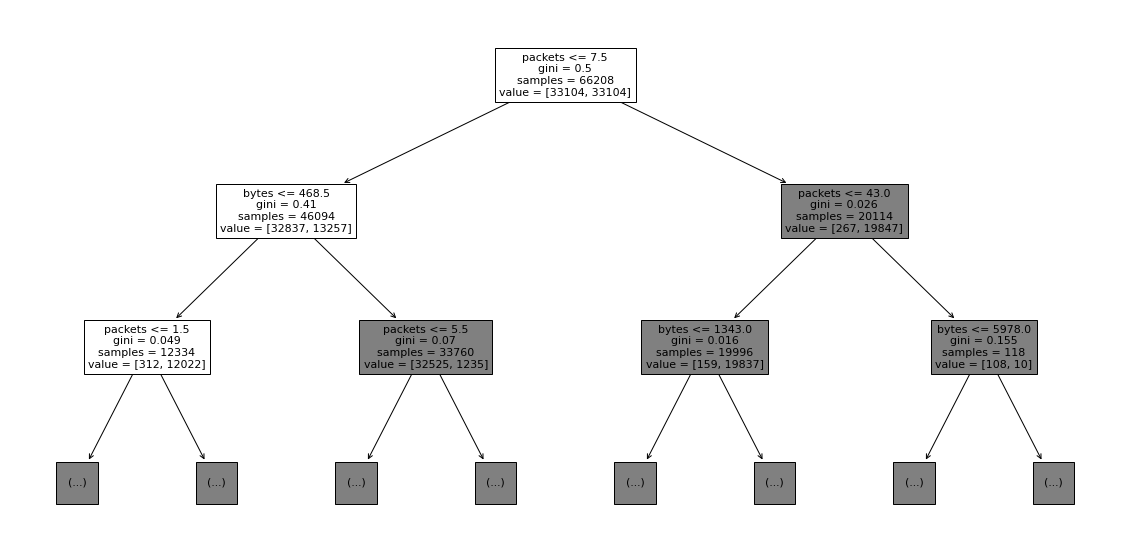

In [33]:
plt.figure(figsize=(20, 10))
plot_tree(tree_model.best_estimator_.named_steps["tree"], feature_names=X_val.columns, max_depth=2); 

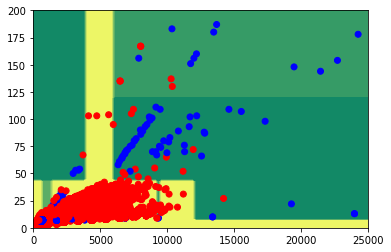

In [32]:
my = tree_model.predict_proba(np.c_[mx1.ravel(), mx2.ravel()])[:, 1].reshape(mx1.shape)
plt.contourf(mx1, mx2, my, cmap="summer")
plt.scatter(X_val["bytes"], X_val["packets"], c=y_val.map(classification_color_map))
plt.axis([0, 25_000, 0, 200]);